In [2]:

from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import pretrainedmodels
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torchnet
import torchvision.models
import os
import argparse
import sys
from torchvision import models as torch_model
#from models import *
sys.path.append("../..")
import backbones.cifar as models
from Utils import adjust_learning_rate, progress_bar, Logger, mkdir_p, Evaluation

from datasets import CellMT_CV,CellMT
model_names = sorted(name for name in models.__dict__
    if not name.startswith("__")
    and callable(models.__dict__[name]))

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"





from torch.utils.data import Subset

from sklearn.model_selection import train_test_split

def __balance_val_split(dataset, val_split=0.):
    targets = np.array(dataset.labels_idx)
    train_indices, val_indices = train_test_split(
        np.arange(targets.shape[0]),
        test_size=val_split,
        stratify=targets,
        random_state=10
    )
    train_dataset = Subset(dataset, indices=train_indices)
    val_dataset = Subset(dataset, indices=val_indices)
    return train_dataset, val_dataset



evaluate = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)




# Data
print('==> Preparing data..')
transform = transforms.Compose([

    transforms.RandomCrop(896),
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),



])


'''30 cell lines with cross validation'''
full_data_path = './data/'
label_id_path_file = "./networks/classification/train_30class_idx.txt"
# test fold
cv_test_fold_id = 1


# full_trainset = CellMT_CV(train_data_path=full_data_path,label_id_path_file = label_id_path_file
#                                ,transform=transform,train=True,shuffle=False,cv_test_fold_id=cv_test_fold_id)
# val_size=0.2
# trainset, valset = __balance_val_split(full_trainset,val_split=val_size)

testset = CellMT(train_data_path=full_data_path,label_id_path_file = label_id_path_file
                                ,transform=transform,train=False,shuffle=False)


# full_data_path = './14CellLines/'
# label_id_path_file = "./OSR/classification/train_14class_idx.txt"


# cellset_14 = CellMT(train_data_path=full_data_path,label_id_path_file = label_id_path_file
#                                ,transform=transform,train=True,shuffle=False)






cuda
==> Preparing data..


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:03<00:00, 24.59it/s]


In [3]:
bs=20
# train_trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=False, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=1)

# testloader_14 = torch.utils.data.DataLoader(cellset_14, batch_size=bs, shuffle=False, num_workers=1)

# Xception with val size 0.2

In [4]:
from Utils import adjust_learning_rate, progress_bar, Logger, mkdir_p, Evaluation
arch = 'Xception'
resume = './checkpoints/Xception_val0.2_testFold1/best_model.pth'.format(arch,10)
evaluate = True

train_class_num = 30
# Only for regression

print('==> Building model..')
#ResNet50
if 'ResNet' in arch:

    net = models.__dict__[arch](num_classes=train_class_num,backbone_fc=True,in_channel=3)

elif arch == 'Xception':
    net = models.xception_cla(num_class=train_class_num,input_channel=1)

# mobilenet_v2 vgg19_bn
else:
    net = torch_model.__dict__[arch](pretrained=False, num_classes=train_class_num)

net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if resume:
    # Load checkpoint.
    if os.path.isfile(resume):

        print('==> Resuming from checkpoint..')
        # change here
        checkpoint = torch.load(resume)
        net.load_state_dict(checkpoint['net'])
        # best_acc = checkpoint['acc']
        # print("BEST_ACCURACY: "+str(best_acc))
        start_epoch = checkpoint['epoch']
        
    else:
        print("=> no checkpoint found at '{}'".format(resume))
   
criterion = nn.CrossEntropyLoss()



epoch=0
val_loss_pre = 9999999
if not evaluate:

    pass


else:
    net.eval()

    test_loss = 0
    correct = 0
    total = 0
    #print(net.module)
    net.eval()

    test_loss = 0
    correct = 0
    total = 0
    #print(net.module)
    predict_results =[]
    labels = []
    net_features = []
    times=[]
    feature_net =  torch.nn.Sequential(*(list(net.module.children())[:-1]))

    
    with torch.no_grad():
        for batch_idx, (inputs, (class_labels, time_points)) in enumerate(testloader):
            inputs, class_labels, time_points = inputs.to(device), class_labels.to(device), time_points.to(device)

            outputs = net(inputs)
            predicted_proba = nn.functional.softmax(outputs,dim=1)
            
            net_feature = feature_net(inputs)
            net_feature=net_feature.view(net_feature.size(0), -1)
            
            
            times.append(time_points)
            net_features.append(net_feature)
            predict_results.append(predicted_proba)
            
            labels.append(class_labels)
            progress_bar(batch_idx, len(testloader))
    
    labels = np.array(torch.cat(labels,dim=0).cpu().numpy())
    
    predict_results = np.array(torch.cat(predict_results,dim=0).cpu().numpy())
    plot_features = np.array(torch.cat(net_features, dim=0).cpu().numpy())
    times = np.array(torch.cat(times,dim=0).cpu().numpy())
#     print("Evaluation...")

#     eval_openmax = Evaluation(predict_results, labels)


#     label_names=[]

#     with open(testset.label_id_path_file, 'r') as f:
#         lines = f.readlines()
#         label_names = [line.rstrip() for line in lines]




#     print(f"%s accuracy is %.3f,f1_score is %.3f"%(arch,eval_openmax.accuracy,eval_openmax.f1_macro))




==> Building model..
==> Resuming from checkpoint..
 [====================================================>............]  Step: 3s264ms | Tot: 4s523ms 5/5 


In [5]:
from sklearn.metrics import accuracy_score,f1_score

test_predited_labels = predict_results.argmax(axis=1)
test_accuracy = accuracy_score(labels,test_predited_labels)
test_f1_macro = f1_score(labels,test_predited_labels,average='macro')
print(f"%s accuracy is %.3f,f1_score is %.3f"%(arch,test_accuracy,test_f1_macro))

Xception accuracy is 1.000,f1_score is 1.000


In [11]:
import numpy as np
folder_name = resume.split('/')[-2]
store_dir_path  = './numpy_array2/'+folder_name+'_base10'

if not os.path.isdir(store_dir_path):
    os.mkdir(store_dir_path)

np.save(store_dir_path+'/test_labels.npy',labels)
np.save(store_dir_path+'/test_results.npy',predict_results)
np.save(store_dir_path+'/test_features.npy',plot_features)
np.save(store_dir_path+'/test_times.npy',times)


In [16]:
'''Training data here'''

net.eval()

test_loss = 0
correct = 0
total = 0
#print(net.module)
train_predict_results =[]
train_labels = []
train_net_features = []
train_times = []
with torch.no_grad():
    for batch_idx, (inputs, (class_labels, time_points)) in enumerate(train_trainloader):
        inputs, class_labels, time_points = inputs.to(device), class_labels.to(device), time_points.to(device)

        outputs = net(inputs)

        _, predicted = outputs.max(1)
        net_feature = feature_net(inputs)
        net_feature=net_feature.view(net_feature.size(0), -1)
            
            
        
            
        train_times.append(time_points)
        train_net_features.append(net_feature)
        train_predict_results.append(predicted)
        
        train_labels.append(class_labels)
        progress_bar(batch_idx, len(train_trainloader))


train_labels = torch.cat(train_labels,dim=0).cpu().numpy()

train_labels = np.array(train_labels)
train_predict_results = np.array(torch.cat(train_predict_results,dim=0).cpu().numpy())
train_plot_features = np.array(torch.cat(train_net_features, dim=0).cpu().numpy())

train_times= np.array(torch.cat(train_times, dim=0).cpu().numpy())




 [================================================================>]  Step: 105ms | Tot: 42s815ms 2352/2352 ............................................................]  Step: 17ms | Tot: 1s873ms 100/2352 =======>.........................................................]  Step: 18ms | Tot: 4s600ms 255/2352 ==================>..............................................]  Step: 18ms | Tot: 12s378ms 665/2352 ===============================>.................................]  Step: 18ms | Tot: 20s683ms 1137/2352 ===============================>.................................]  Step: 17ms | Tot: 20s883ms 1148/2352 .]  Step: 18ms | Tot: 22s211ms 1222/2352 ===>..............................]  Step: 18ms | Tot: 22s431ms 1234/2352 ========================================>........................]  Step: 17ms | Tot: 26s776ms 1478/2352 =========================================>.......................]  Step: 16ms | Tot: 27s64ms 1495/2352 ===========================================>.........

In [17]:
import numpy as np
np.save(store_dir_path+'/train_labels.npy',train_labels)
np.save(store_dir_path+'/train_results.npy',train_predict_results)
np.save(store_dir_path+'/train_features.npy',train_plot_features)
np.save(store_dir_path+'/train_times.npy',train_times)

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
reg_model = LinearRegression().fit(train_plot_features,train_times*15.5)

reg_predicted_times = reg_model.predict(plot_features)
reg_train_predicted_time = reg_model.predict(train_plot_features)
print("train MSE = {}, test MSE = {}".format(mean_squared_error(reg_train_predicted_time,train_times*15.5),
                                             
                                            mean_squared_error(reg_predicted_times,times*15.5)))

train MSE = 2.9122723044669183e-07, test MSE = 0.804065391740628


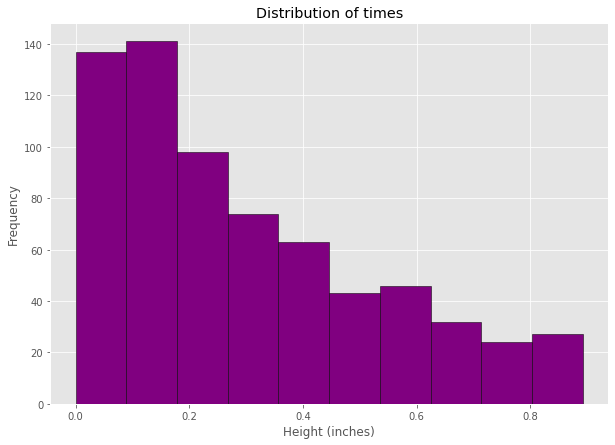

In [84]:
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')

df= pd.DataFrame()
df['times'] = train_times

# histogram of the height
df.times.plot(kind='hist', color='purple', edgecolor='black', figsize=(10,7))
plt.title('Distribution of times')
plt.xlabel('Height (inches)')
plt.ylabel('Frequency')
plt.show()

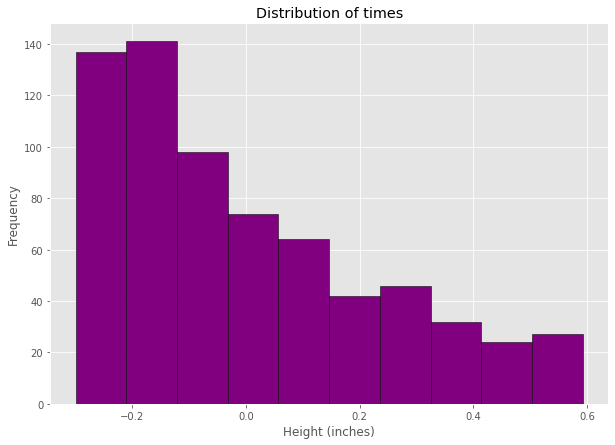

In [158]:
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('ggplot')

df= pd.DataFrame()
df['times'] = train_times - y_offset

# histogram of the height
df.times.plot(kind='hist', color='purple', edgecolor='black', figsize=(10,7))
plt.title('Distribution of times')
plt.xlabel('Height (inches)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# import numpy as np
# np.save(store_dir_path+'/train_labels.npy',train_labels)
# np.save(store_dir_path+'/train_predict_results.npy',train_predict_results)
# np.save(store_dir_path+'/train_plot_features.npy',train_plot_features)
# np.save(store_dir_path+'/train_times.npy',train_times)

In [ ]:
import numpy as np

# train_labels = np.load('./figures/numpy_data/multitask_class30_val0.2_train/train_labels.npy')
# train_MultiTask_plot_features=np.load('./figures/numpy_data/multitask_class30_val0.2_train/train_MultiTask_plot_features.npy')
# train_times=np.load('./figures/numpy_data/multitask_class30_val0.2_train/train_times.npy')

# labels = np.load('./figures/numpy_data/multitask_class30_val0.2_test/labels.npy')
# MultiTask_plot_features = np.load('./figures/numpy_data/multitask_class30_val0.2_test/MultiTask_plot_features.npy')
# times = np.load('./figures/numpy_data/multitask_class30_val0.2_test/times.npy')

In [ ]:
train_max_timep = 15.5
test_max_timep = 15.5
# GT_label = np.concatenate((train_labels,labels))
# GT_times = np.concatenate((train_times*train_max_timep,times*test_max_timep))
cnn_featuress = np.concatenate((train_plot_features,plot_features),axis=0)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
X_tsne = TSNE(n_components=2,perplexity=50,verbose=1)
x_embeded = X_tsne.fit_transform(cnn_featuress)

In [ ]:
np.save(store_dir_path+'/data_tsne.npy',x_embeded)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np



#Get the confusion matrix
cm = confusion_matrix(labels, predict_results)
#array([[1, 0, 0],
#   [1, 0, 0],
#   [0, 1, 2]])

#Now the normalize the diagonal entries
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#array([[1.        , 0.        , 0.        ],
#      [1.        , 0.        , 0.        ],
#      [0.        , 0.33333333, 0.66666667]])

#The diagonal entries are the accuracies of each class
for ids,acc in enumerate(cm.diagonal()):
    print('{} acc: {}'.format(label_names[ids],acc))
    


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns


# fig,axs=plt.subplots(nrows=1,ncols=1,figsize=(40, 40))
# eval_openmax.plot_confusion_matrix(ax=axs,labels=label_names)


# plt.show()

# Training CLRNet

In [1]:
import numpy as np
base_numb = 20


folder_name = 'Xception_val0.2_testFold1'
store_dir_path  = '/projects/img/cellbank/Close_set_Classification/numpy_array/'+folder_name



train_labels_30 =  np.load(store_dir_path+'/train_labels.npy')
train_features_30 = np.load(store_dir_path+'/train_features.npy')
train_times_30 =  np.load(store_dir_path+'/train_times.npy')

# val_labels_30 =  np.load(store_dir_path+'/val_labels.npy')
# val_features_30 = np.load(store_dir_path+'/val_features.npy')
# val_times_30 =  np.load(store_dir_path+'/val_times.npy')

In [2]:
import torch
from torch.autograd import Variable
from Utils import adjust_learning_rate, progress_bar, Logger, mkdir_p, Evaluation
import torch.nn.functional as F
import torch.utils.data as Data
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import imageio
import os
from torch import nn,optim
torch.manual_seed(1)    # reproducible
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,f1_score

#CLRNet
net = torch.nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 16), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(16,1),
    
    
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = net.to(device)
def adjust_learning_rate(optimizer, epoch, lr,factor=0.1, step=25):
    """Sets the learning rate to the initial LR decayed by factor every step epochs"""
    lr = lr * (factor ** (epoch // step))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


lr = 0.0001
optimizer = torch.optim.Adam(net.parameters()
                          , lr=lr)
# optimizer = optim.SGD(net.parameters()
#                       , lr=lr, momentum=0.9, weight_decay=5e-4)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

BATCH_SIZE = 20
EPOCH = 100

train_features_30, train_times_30 = torch.tensor(train_features_30),torch.tensor(train_times_30)
train_features_30, train_times_30 = Variable(train_features_30),Variable(train_times_30)
val_features_30, val_times_30 = torch.tensor(val_features_30),torch.tensor(val_times_30)


train_dataset = Data.TensorDataset(train_features_30, train_times_30)
trainloader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

val_dataset = Data.TensorDataset(val_features_30,val_times_30)
valloader = Data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)



save_checkpoint='./checkpoints/Xception_val0.2_testFold1/'    
if not os.path.isdir(save_checkpoint):
    os.mkdir(save_checkpoint)    


def train(net,trainloader,optimizer,criterion,device):
    net.train()
    train_loss = 0


    for batch_idx, (inputs, targets) in enumerate(trainloader):
        optimizer.zero_grad()
        inputs = Variable(inputs)
        targets = Variable(targets)
        
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        targets = targets.type(outputs.dtype)
    
        loss = criterion(outputs.float(), targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f'
            % (train_loss/(batch_idx+1)))
    return train_loss/(batch_idx+1)

#Validation
def Validation(net,valloader,optimizer,criterion,device):
    net.eval()

    val_loss = 0

    scores, labels = [], []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            # unified float and double

            loss = criterion(outputs.float(), targets)
            val_loss += loss.item()
            # _, predicted = outputs.max(1)



    return val_loss/(batch_idx+1)

def save_model(net, acc, epoch, path):
    print('Saving..')
    state = {
        'net': net.state_dict(),
        'testacc': acc,
        'epoch': epoch,
    }
    torch.save(state, path)


val_loss_pre=99999999
for epoch in range(EPOCH):
    print('\nEpoch: %d   Learning rate: %f' % (epoch+1, optimizer.param_groups[0]['lr']))
    adjust_learning_rate(optimizer, epoch, lr,step=5)
    train_loss = train(net,trainloader,optimizer,loss_func,device)
    # Validation

   
    #val_loss = validation(net,valloader,optimizer,loss_func,device)
    if (epoch+1)>50:
        val_loss = Validation(net, valloader, optimizer, criterion, device)
        print('\n Validation MES Loss: %f'%(val_loss))
        if val_loss < val_loss_pre:
            print('-------val loss decrease, save best model now-----------')
            val_loss_pre = val_loss
            save_model(net, None, epoch, os.path.join(save_checkpoint,'regression_model.pth'))


            
            

            




Epoch: 1   Learning rate: 0.000100


/projects/img/cellbank/conda_envs/tensorflow_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


 [================================================================>]  Step: 6ms | Tot: 3m26s | Loss: 2382.186 35278/35278    ..]  Step: 7ms | Tot: 797ms | Loss: 14566.049 139/35278 .........................]  Step: 6ms | Tot: 1s15ms | Loss: 14535.035 177/35278 .............................................]  Step: 5ms | Tot: 1s855ms | Loss: 12322.080 320/35278 ............]  Step: 6ms | Tot: 1s904ms | Loss: 12219.145 328/35278 >................................................................]  Step: 5ms | Tot: 2s216ms | Loss: 11653.100 382/35278 .....................................]  Step: 5ms | Tot: 3s8ms | Loss: 10154.303 522/35278 ..................................]  Step: 6ms | Tot: 3s14ms | Loss: 10137.028 523/35278 ..................]  Step: 7ms | Tot: 3s288ms | Loss: 9682.895 570/35278 ................................................]  Step: 7ms | Tot: 3s535ms | Loss: 9300.540 610/35278 ..........................................................]  Step: 6ms | Tot: 3s737ms | Loss:

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [================================================================>]  Step: 6ms | Tot: 3m26s | Loss: 1423.124 35278/35278    ..........]  Step: 6ms | Tot: 25s499ms | Loss: 1461.521 4354/35278 ............]  Step: 6ms | Tot: 25s533ms | Loss: 1462.323 4360/35278 ..............................................]  Step: 5ms | Tot: 25s595ms | Loss: 1463.468 4370/35278 ........................................]  Step: 6ms | Tot: 25s727ms | Loss: 1467.474 4393/35278 ...........]  Step: 6ms | Tot: 25s875ms | Loss: 1470.657 4419/35278 .....................................]  Step: 5ms | Tot: 25s893ms | Loss: 1471.318 4422/35278 ...............................]  Step: 5ms | Tot: 25s963ms | Loss: 1475.238 4434/35278 ...............]  Step: 5ms | Tot: 26s205ms | Loss: 1484.278 4477/35278 ...................................]  Step: 5ms | Tot: 26s275ms | Loss: 1490.896 4489/35278 =====>........................................................]  Step: 5ms | Tot: 26s298ms | Loss: 1502.443 4493/35278 ......

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [================================================================>]  Step: 5ms | Tot: 3m26s | Loss: 1324.755 35278/35278    ........................]  Step: 6ms | Tot: 31s987ms | Loss: 1473.872 5407/35278 ..............]  Step: 6ms | Tot: 32s445ms | Loss: 1476.448 5487/35278 ===>......................................................]  Step: 6ms | Tot: 32s502ms | Loss: 1480.281 5497/35278 ...........]  Step: 6ms | Tot: 32s639ms | Loss: 1488.801 5519/35278 .................................]  Step: 6ms | Tot: 32s646ms | Loss: 1488.533 5520/35278 ==========>......................................................]  Step: 5ms | Tot: 32s847ms | Loss: 1494.238 5554/35278 ....................]  Step: 5ms | Tot: 32s878ms | Loss: 1496.267 5559/35278 ...............................]  Step: 6ms | Tot: 32s902ms | Loss: 1495.315 5563/35278 ........................]  Step: 5ms | Tot: 33s181ms | Loss: 1503.130 5608/35278 .............................]  Step: 6ms | Tot: 33s325ms | Loss: 1507.523 5633/35

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [================================================================>]  Step: 5ms | Tot: 3m26s | Loss: 1346.614 35278/35278    =====>......................]  Step: 6ms | Tot: 2m14s | Loss: 1378.702 22921/35278 ===========>......................]  Step: 6ms | Tot: 2m14s | Loss: 1378.628 22925/35278 ================>......................]  Step: 6ms | Tot: 2m14s | Loss: 1378.186 22937/35278 ................]  Step: 6ms | Tot: 2m14s | Loss: 1377.702 22949/35278 ======================>......................]  Step: 6ms | Tot: 2m15s | Loss: 1378.363 23018/35278 ==============================>......................]  Step: 5ms | Tot: 2m15s | Loss: 1378.716 23031/35278 .............]  Step: 6ms | Tot: 2m15s | Loss: 1379.443 23047/35278 ......................]  Step: 7ms | Tot: 2m15s | Loss: 1379.659 23061/35278 ...............]  Step: 5ms | Tot: 2m15s | Loss: 1379.605 23062/35278 ====>......................]  Step: 6ms | Tot: 2m15s | Loss: 1379.708 23084/35278 =================================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [================================================================>]  Step: 5ms | Tot: 3m26s | Loss: 1375.190 35278/35278   Step: 7ms | Tot: 1m43s | Loss: 1412.617 17783/35278 ............................]  Step: 5ms | Tot: 1m44s | Loss: 1403.922 17957/35278 =>...............................]  Step: 6ms | Tot: 1m45s | Loss: 1408.138 18007/35278   Step: 5ms | Tot: 1m45s | Loss: 1410.080 18109/35278 ......................]  Step: 6ms | Tot: 1m46s | Loss: 1412.637 18144/35278 ==>...............................]  Step: 5ms | Tot: 1m46s | Loss: 1412.868 18150/35278 ====>...............................]  Step: 6ms | Tot: 1m46s | Loss: 1412.791 18151/35278 ===========================>...............................]  Step: 5ms | Tot: 1m46s | Loss: 1412.713 18178/35278 ===>...............................]  Step: 6ms | Tot: 1m46s | Loss: 1417.471 18252/35278 =======>...............................]  Step: 6ms | Tot: 1m47s | Loss: 1420.323 18334/35278 ....................]  Step: 5ms | Tot: 1m47

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [================================================================>]  Step: 6ms | Tot: 3m27s | Loss: 1358.675 35278/35278  ===>....]  Step: 6ms | Tot: 3m13s | Loss: 1392.846 32994/35278 =================================================>....]  Step: 5ms | Tot: 3m13s | Loss: 1392.928 33035/35278 ==============================================>....]  Step: 7ms | Tot: 3m13s | Loss: 1392.740 33040/35278 ================================>....]  Step: 5ms | Tot: 3m14s | Loss: 1391.889 33067/35278 ====>...]  Step: 5ms | Tot: 3m14s | Loss: 1388.398 33217/35278 ==========================================================>...]  Step: 7ms | Tot: 3m15s | Loss: 1387.817 33238/35278 ====================>...]  Step: 5ms | Tot: 3m16s | Loss: 1387.082 33495/35278 =>...]  Step: 5ms | Tot: 3m16s | Loss: 1387.053 33532/35278 =============================================================>...]  Step: 5ms | Tot: 3m16s | Loss: 1387.015 33533/35278 =============================================================>...]  

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [================================================================>]  Step: 5ms | Tot: 3m26s | Loss: 1366.860 35278/35278   =========================================>.....................]  Step: 6ms | Tot: 2m18s | Loss: 1395.375 23534/35278 ..........]  Step: 7ms | Tot: 2m18s | Loss: 1399.395 23632/35278 ===============================>.....................]  Step: 7ms | Tot: 2m19s | Loss: 1399.966 23696/35278 .....]  Step: 7ms | Tot: 2m19s | Loss: 1399.967 23823/35278 =============================>....................]  Step: 5ms | Tot: 2m21s | Loss: 1390.386 24099/35278 ===========================================>....................]  Step: 5ms | Tot: 2m21s | Loss: 1390.884 24183/35278 =============================>....................]  Step: 6ms | Tot: 2m22s | Loss: 1391.432 24289/35278 ===========================>....................]  Step: 6ms | Tot: 2m22s | Loss: 1392.239 24306/35278 ==>....................]  Step: 5ms | Tot: 2m23s | Loss: 1391.203 24394/35278 ===============

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [================================================================>]  Step: 5ms | Tot: 3m26s | Loss: 1352.252 35278/35278      Step: 5ms | Tot: 1m3s | Loss: 1328.430 10793/35278 ..................................]  Step: 6ms | Tot: 1m3s | Loss: 1328.277 10832/35278 =>............................................]  Step: 5ms | Tot: 1m3s | Loss: 1327.291 10867/35278 =====>............................................]  Step: 7ms | Tot: 1m3s | Loss: 1327.932 10883/35278   Step: 6ms | Tot: 1m4s | Loss: 1329.455 11000/35278 ...................]  Step: 6ms | Tot: 1m4s | Loss: 1329.209 11055/35278 ..................................]  Step: 5ms | Tot: 1m4s | Loss: 1331.164 11072/35278 .................]  Step: 6ms | Tot: 1m9s | Loss: 1417.412 11807/35278 ............]  Step: 5ms | Tot: 1m9s | Loss: 1417.037 11835/35278 ==========>...........................................]  Step: 7ms | Tot: 1m9s | Loss: 1416.593 11845/35278 ........]  Step: 6ms | Tot: 1m9s | Loss: 1415.902 11855/35278 .........

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [================================================================>]  Step: 5ms | Tot: 3m27s | Loss: 1341.573 35278/35278    .............................................]  Step: 6ms | Tot: 17s87ms | Loss: 1467.942 2889/35278 ............................................]  Step: 6ms | Tot: 17s186ms | Loss: 1463.504 2906/35278 ......................]  Step: 5ms | Tot: 17s237ms | Loss: 1461.910 2915/35278 .........]  Step: 5ms | Tot: 17s340ms | Loss: 1458.045 2932/35278 ....]  Step: 7ms | Tot: 17s842ms | Loss: 1436.929 3020/35278 ................................]  Step: 6ms | Tot: 18s918ms | Loss: 1378.097 3210/35278 .........................................]  Step: 6ms | Tot: 19s188ms | Loss: 1375.291 3256/35278 ======>..........................................................]  Step: 6ms | Tot: 19s413ms | Loss: 1364.158 3295/35278 .............................................]  Step: 5ms | Tot: 19s453ms | Loss: 1361.509 3302/35278 ..............]  Step: 6ms | Tot: 19s899ms | Loss: 1337.

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [================================================================>]  Step: 4ms | Tot: 3m27s | Loss: 1360.695 35278/35278 8 Step: 5ms | Tot: 2m55s | Loss: 1368.640 29761/35278 ==>.........]  Step: 6ms | Tot: 2m55s | Loss: 1365.900 29866/35278 ===================>.........]  Step: 6ms | Tot: 2m55s | Loss: 1365.059 29891/35278 ======================>.........]  Step: 6ms | Tot: 2m55s | Loss: 1364.482 29913/35278 =>.........]  Step: 5ms | Tot: 2m56s | Loss: 1362.878 29954/35278 ....]  Step: 5ms | Tot: 2m57s | Loss: 1359.412 30091/35278 ===========================>.........]  Step: 5ms | Tot: 2m57s | Loss: 1358.688 30144/35278 ......]  Step: 5ms | Tot: 2m57s | Loss: 1358.668 30186/35278 =========>.........]  Step: 5ms | Tot: 2m57s | Loss: 1358.684 30235/35278 ==>.........]  Step: 5ms | Tot: 2m58s | Loss: 1358.755 30277/35278 =================================>.........]  Step: 7ms | Tot: 2m58s | Loss: 1358.862 30301/35278 ===============>.........]  Step: 6ms | Tot: 2m58s | Loss: 1359.149 3

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [================================================================>]  Step: 5ms | Tot: 3m27s | Loss: 1357.406 35278/35278    .....................................]  Step: 5ms | Tot: 19s538ms | Loss: 1371.878 3284/35278 ..]  Step: 7ms | Tot: 19s557ms | Loss: 1370.749 3287/35278 ........................................]  Step: 7ms | Tot: 19s575ms | Loss: 1369.867 3290/35278 .....................]  Step: 5ms | Tot: 19s722ms | Loss: 1362.707 3316/35278 ...]  Step: 5ms | Tot: 19s768ms | Loss: 1359.996 3324/35278 .....]  Step: 6ms | Tot: 20s115ms | Loss: 1341.538 3385/35278 ........................]  Step: 7ms | Tot: 20s456ms | Loss: 1326.599 3445/35278 .........................]  Step: 6ms | Tot: 20s758ms | Loss: 1325.670 3497/35278 ............]  Step: 6ms | Tot: 20s804ms | Loss: 1325.754 3505/35278 ======>..........................................................]  Step: 6ms | Tot: 21s192ms | Loss: 1329.242 3566/35278 ......................]  Step: 5ms | Tot: 21s249ms | Loss: 1328.806 357

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [================================================================>]  Step: 6ms | Tot: 3m26s | Loss: 1353.811 35278/35278   ...........]  Step: 6ms | Tot: 1m14s | Loss: 1377.791 12657/35278 ...........]  Step: 6ms | Tot: 1m14s | Loss: 1378.686 12689/35278 .........]  Step: 7ms | Tot: 1m14s | Loss: 1376.741 12719/35278 .]  Step: 7ms | Tot: 1m14s | Loss: 1375.557 12739/35278 >.........................................]  Step: 6ms | Tot: 1m14s | Loss: 1375.230 12795/35278 ======================>.........................................]  Step: 6ms | Tot: 1m14s | Loss: 1375.475 12801/35278 ....................................]  Step: 6ms | Tot: 1m15s | Loss: 1375.625 12817/35278 ===>.........................................]  Step: 6ms | Tot: 1m15s | Loss: 1376.699 12855/35278 =============>.........................................]  Step: 5ms | Tot: 1m15s | Loss: 1376.883 12857/35278 ...............................]  Step: 6ms | Tot: 1m15s | Loss: 1376.930 12859/35278 >....................

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [================================================================>]  Step: 5ms | Tot: 3m26s | Loss: 1372.841 35278/35278   ===========================>.......................]  Step: 6ms | Tot: 2m11s | Loss: 1388.219 22402/35278 ==============================>.......................]  Step: 6ms | Tot: 2m11s | Loss: 1391.546 22451/35278 ..............]  Step: 6ms | Tot: 2m11s | Loss: 1392.069 22453/35278 ....................]  Step: 6ms | Tot: 2m12s | Loss: 1394.792 22508/35278   Step: 6ms | Tot: 2m12s | Loss: 1395.033 22514/35278 ]  Step: 5ms | Tot: 2m13s | Loss: 1399.162 22751/35278 ................]  Step: 7ms | Tot: 2m13s | Loss: 1399.322 22759/35278 ===============================>.......................]  Step: 6ms | Tot: 2m13s | Loss: 1399.028 22768/35278 ...]  Step: 5ms | Tot: 2m13s | Loss: 1398.827 22773/35278 =====================================>......................]  Step: 5ms | Tot: 2m13s | Loss: 1398.798 22802/35278 ......]  Step: 6ms | Tot: 2m15s | Loss: 1404.716 23046

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 [================================================================>]  Step: 6ms | Tot: 3m26s | Loss: 1357.289 35278/35278 =======================>.]  Step: 6ms | Tot: 3m20s | Loss: 1383.587 34297/35278 =============================================>.]  Step: 5ms | Tot: 3m20s | Loss: 1380.914 34396/35278 =====>.]  Step: 5ms | Tot: 3m21s | Loss: 1378.601 34479/35278 ===>.]  Step: 6ms | Tot: 3m21s | Loss: 1378.528 34481/35278 ======>.]  Step: 7ms | Tot: 3m21s | Loss: 1377.618 34513/35278 ====================>.]  Step: 5ms | Tot: 3m21s | Loss: 1377.586 34514/35278 ========================>.]  Step: 6ms | Tot: 3m21s | Loss: 1376.830 34544/35278 >.]  Step: 5ms | Tot: 3m22s | Loss: 1374.418 34618/35278 ==>.]  Step: 6ms | Tot: 3m22s | Loss: 1373.894 34643/35278 =============================>.]  Step: 6ms | Tot: 3m22s | Loss: 1371.503 34735/35278 ================================================================>]  Step: 5ms | Tot: 3m23s | Loss: 1370.638 34767/35278 ======================>]  Step:

# Transfer Learning data loading

In [16]:
import numpy as np
base_numb = 20


folder_name = 'Xception_base{}'.format(base_numb)
store_dir_path  = './numpy_array2/'+folder_name
store_dir_path_TF  = './numpy_array2/'+folder_name+'_TF'


test_labels_30 = np.load(store_dir_path+'/test_labels.npy')
test_features_30 = np.load(store_dir_path+'/test_features.npy')
test_times_30 = np.load(store_dir_path+'/test_times.npy')

train_labels_30 =  np.load(store_dir_path+'/train_labels.npy')
train_features_30 = np.load(store_dir_path+'/train_features.npy')
train_times_30 =  np.load(store_dir_path+'/train_times.npy')

labels_14 = np.load(store_dir_path+'/train_labels_14.npy')
features_14 = np.load(store_dir_path+'/train_features_14.npy')
times_14 =  np.load(store_dir_path+'/train_times_14.npy')




In [17]:
import os 

selected_base_names = os.listdir('./DATA_WELL_CV/Fold1/')[:base_numb]

In [18]:
label_names_14=[]
label_names_30=[]
with open('./OSR/classification/train_14class_idx.txt', 'r') as f:
    lines = f.readlines()
    label_names_14 = [line.rstrip() for line in lines]
with open('./OSR/classification/train_30class_idx.txt', 'r') as f:
    lines = f.readlines()
    label_names_30 = [line.rstrip() for line in lines]

In [19]:
label_names_30

['A431',
 'A549',
 'BT474',
 'HCC 2279',
 'HCC1395',
 'HCC70',
 'HCC78',
 'HCC827',
 'HS-5',
 'HT 1080',
 'Hop62',
 'KELLY',
 'KPL4',
 'LNCAP',
 'LU99',
 'LUHMES',
 'MCF10A',
 'MDA MB 231',
 'Mia Paca2',
 'NCI H1933',
 'NCI H1975',
 'NCI H2030',
 'NCI H2073',
 'NCI H358',
 'PC3',
 'SKBR3',
 'SNU1411',
 'SNU601',
 'SUM149PT',
 'T47D']

In [20]:
np.unique(test_labels_30)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [21]:
string_labels_14 = [label_names_14[ids] for ids in labels_14]
string_test_labels_30 = [label_names_30[ids] for ids in test_labels_30]
string_train_labels_30 = [label_names_30[ids] for ids in train_labels_30]

# # convert to 44 classes
# with open('./OSR/classification/train_44class_idx.txt', 'r') as f:
#     lines = f.readlines()
#     lines = [line.rstrip() for line in lines]
    
#     labels_14 = [lines.index(string_label.rstrip()) for string_label in string_labels_14]
#     test_labels_30 = [lines.index(string_label.rstrip()) for string_label in string_test_labels_30]
#     train_labels_30 = [lines.index(string_label.rstrip()) for string_label in string_train_labels_30]

In [22]:
# transfer learning base training


Selected_string_test_labels_30 = [string_label for string_label in string_test_labels_30 if string_label in selected_base_names]
Selected_string_train_labels_30 = [string_label for string_label in string_train_labels_30 if string_label in selected_base_names]


test_features_30 = [test_features_30[ids] for ids,string_label in enumerate(string_test_labels_30) if string_label in selected_base_names]
test_times_30 = [test_times_30[ids] for ids,string_label in enumerate(string_test_labels_30) if string_label in selected_base_names]


train_features_30 = [train_features_30[ids] for ids,string_label in enumerate(string_train_labels_30) if string_label in selected_base_names]
train_times_30 =  [train_times_30[ids] for ids,string_label in enumerate(string_train_labels_30) if string_label in selected_base_names]


new_id_file =  os.path.join(store_dir_path,"id_file_{}.txt".format(base_numb))

with open(new_id_file, 'w') as f:
    labels_strings = np.concatenate((np.unique(Selected_string_train_labels_30),np.unique(string_labels_14)))   
    f.writelines([line + '\n' for line in labels_strings])
    
with open(new_id_file, 'r') as f:
    lines = f.readlines()
    lines = [line.rstrip() for line in lines]
    
    labels_14 = [lines.index(string_label.rstrip()) for string_label in string_labels_14]
    test_labels_30 = [lines.index(string_label.rstrip()) for string_label in Selected_string_test_labels_30]
    train_labels_30 = [lines.index(string_label.rstrip()) for string_label in Selected_string_train_labels_30]
    


# Transfer learning 

In [23]:
import torch
from torch.autograd import Variable
from Utils import adjust_learning_rate, progress_bar, Logger, mkdir_p, Evaluation
import torch.nn.functional as F
import torch.utils.data as Data
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import imageio
import os
from torch import nn,optim
torch.manual_seed(1)    # reproducible
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,f1_score

net = torch.nn.Sequential(
        nn.Linear(2048, base_numb+14),  
    )
# CLRNet
# net = torch.nn.Sequential(
#         nn.Linear(2048, 512),
#         nn.ReLU(),
#         nn.Dropout(0.5),
#         nn.Linear(512, 128),
#         nn.ReLU(),
#         nn.Dropout(0.5),
#         nn.Linear(128, 16), 
#         nn.ReLU(),
#         nn.Dropout(0.5),
#         nn.Linear(16,1)
#     )

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = net.to(device)
def adjust_learning_rate(optimizer, epoch, lr,factor=0.1, step=20):
    """Sets the learning rate to the initial LR decayed by factor every step epochs"""
    lr = lr * (factor ** (epoch // step))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


lr = 0.001
# optimizer = torch.optim.Adam(net.parameters()
#                           , lr=lr)
optimizer = optim.SGD(net.parameters()
                          , lr=lr, momentum=0.9, weight_decay=5e-4)
loss_func = torch.nn.CrossEntropyLoss()  # this is for regression mean squared loss

BATCH_SIZE = 30
EPOCH = 10

import numpy as np
from sklearn.model_selection import KFold
X = features_14
y = np.array(labels_14)

kf = KFold(n_splits=5,shuffle=True,random_state=1)
kf.get_n_splits(X)

for kf_ids,(train_index, test_index) in enumerate(kf.split(X)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = np.concatenate((train_features_30,X_train),axis=0)
    y_train = np.concatenate((train_labels_30,y_train),axis=0)
    z_train = np.concatenate((train_times_30,times_14[train_index]),axis=0)
    
    X_test = np.concatenate((test_features_30,X_test),axis=0)
    y_test = np.concatenate((test_labels_30,y_test),axis=0)
    z_test = np.concatenate((test_times_30,times_14[test_index]),axis=0)

    X_train,y_train,z_train = torch.tensor(X_train), torch.tensor(y_train),torch.tensor(z_train)
    X_train, y_train,z_train = Variable(X_train), Variable(y_train),Variable(z_train)

    train_dataset = Data.TensorDataset(X_train, y_train,z_train)

    train_loader = Data.DataLoader(
        dataset=train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, num_workers=2)
    
    
    folder_name = 'fold{}'.format(kf_ids+1)
    if not os.path.isdir('./numpy_array2/transfer_learning_base{}/'.format(base_numb)):
        os.mkdir('./numpy_array2/transfer_learning_base{}/'.format(base_numb))
    store_dir_path  = './numpy_array2/transfer_learning_base{}/'.format(base_numb)+folder_name
    print(store_dir_path)
    
    if not os.path.isdir(store_dir_path):
        os.mkdir(store_dir_path)    
    
    logger = Logger(os.path.join(store_dir_path, 'log.txt'))
     
    logger.set_names(['Epoch', 'Learning Rate', 'Train Loss','Train Acc.'])
    
    net.train()
    # start training
    start_time = time.time()
    
    for epoch in range(EPOCH):
        train_loss = 0
        correct = 0
        total = 0
        adjust_learning_rate(optimizer, epoch, lr,step=20)

        for step, (batch_x, batch_y,batch_z) in enumerate(train_loader): # for each training step
            optimizer.zero_grad()
            
            
            b_x = Variable(batch_x)
            b_y = Variable(batch_y)
            b_z = Variable(batch_z)
            
            b_x, b_y, b_z = b_x.to(device), b_y.to(device), b_z.to(device)

            prediction = net(b_x)     # input x and predict based on x
    
            loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)
            
               # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients

            train_loss += loss.item()
            _, predicted = prediction.max(1)
            total += b_y.size(0)
            correct += predicted.eq(b_y).sum().item()

        progress_bar(epoch, EPOCH)
        
        logger.append([epoch+1, optimizer.param_groups[0]['lr'], train_loss/(step+1), 100.*correct/total])
        
    end_time = round(time.time() - start_time, 2)
    with open(os.path.join(store_dir_path, 'log.txt'),'a+') as f:
        f.write("Training time: {}\n".format(end_time))
    
    
    net.eval()
    print("Evaluation...")
    

    X_test,y_test,z_test = torch.tensor(X_test), torch.tensor(y_test),torch.tensor(z_test)
    X_test, y_test,z_test = Variable(X_test), Variable(y_test),Variable(z_test)

    test_dataset = Data.TensorDataset(X_test, y_test,z_test)

    test_loader = Data.DataLoader(
        dataset=test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, num_workers=2)

    

    predict_results =[]
    labels = []
    net_features = []
    times=[]
    
    with torch.no_grad():
        for step, (batch_x, batch_y,batch_z) in enumerate(test_loader):

            b_x = Variable(batch_x)
            b_y = Variable(batch_y)
            b_z = Variable(batch_z)
            b_x, b_y, b_z = b_x.to(device), b_y.to(device), b_z.to(device)
            
            outputs = net(b_x)
            predicted_proba = nn.functional.softmax(outputs,dim=1)

            times.append(b_z)
            net_features.append(b_x)
            predict_results.append(predicted_proba)
            
            labels.append(b_y)
            progress_bar(step, len(test_loader))
    
    labels = np.array(torch.cat(labels,dim=0).cpu().numpy())
    predict_results = np.array(torch.cat(predict_results,dim=0).cpu().numpy())
    plot_features = np.array(torch.cat(net_features, dim=0).cpu().numpy())
    times = np.array(torch.cat(times,dim=0).cpu().numpy())

    test_predited_labels = predict_results.argmax(axis=1)
    test_accuracy = accuracy_score(labels,test_predited_labels)
    test_f1_macro = f1_score(labels,test_predited_labels,average='macro')
    print(f"Fold%d accuracy is %.3f,f1_score is %.3f"%(kf_ids,test_accuracy,test_f1_macro))
    
    np.save(store_dir_path+'/test_labels.npy',labels)
    np.save(store_dir_path+'/test_results.npy',predict_results)
    np.save(store_dir_path+'/test_features.npy',plot_features)
    np.save(store_dir_path+'/test_times.npy',times)
    
    net.eval()

    
    #print(net.module)
    train_predict_results =[]
    train_labels = []
    train_net_features = []
    train_times = []
    
    with torch.no_grad():
        for step, (batch_x, batch_y,batch_z) in enumerate(train_loader):
            
            b_x = Variable(batch_x)
            b_y = Variable(batch_y)
            b_z = Variable(batch_z)
            b_x, b_y, b_z = b_x.to(device), b_y.to(device), b_z.to(device)
            outputs = net(b_x)

            _, predicted = outputs.max(1)
            


            train_times.append(b_z)
            train_net_features.append(b_x)
            train_predict_results.append(predicted)

            train_labels.append(b_y)
            progress_bar(step, len(train_loader))


    train_labels = np.array(torch.cat(train_labels,dim=0).cpu().numpy())
    train_predict_results = np.array(torch.cat(train_predict_results,dim=0).cpu().numpy())
    train_plot_features = np.array(torch.cat(train_net_features, dim=0).cpu().numpy())
    train_times= np.array(torch.cat(train_times, dim=0).cpu().numpy())
    
    np.save(store_dir_path+'/train_labels.npy',train_labels)
    np.save(store_dir_path+'/train_results.npy',train_predict_results)
    np.save(store_dir_path+'/train_features.npy',train_plot_features)
    np.save(store_dir_path+'/train_times.npy',train_times)


        
        

./numpy_array2/transfer_learning_base20/fold1
 [==============================================================>..]  Step: 2s693ms | Tot: 1m23s 30/30 0  
Evaluation...
 [================================================================>]  Step: 3ms | Tot: 1s581ms 201/201 ................]  Step: 5ms | Tot: 1s234ms 112/201  157/201   Step: 5ms | Tot: 1s453ms 169/201   Step: 5ms | Tot: 1s465ms 172/201 ===================================================>.....]  Step: 6ms | Tot: 1s519ms 184/201 ===================================>.]  Step: 3ms | Tot: 1s566ms 197/201 
Fold0 accuracy is 0.992,f1_score is 0.952
 [================================================================>]  Step: 3ms | Tot: 2s471ms 649/649 .....................]  Step: 4ms | Tot: 523ms 104/649 .....................]  Step: 5ms | Tot: 895ms 212/649  261/649 ..............]  Step: 6ms | Tot: 1s382ms 351/649 ==================>.........................]  Step: 5ms | Tot: 1s562ms 399/649   Step: 3ms | Tot: 1s602ms 410/649 ===

In [15]:
for kf_ids,(train_index, test_index) in enumerate(kf.split(X)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train = np.concatenate((train_features_30,X_train),axis=0)
    y_train = np.concatenate((train_labels_30,y_train),axis=0)
    z_train = np.concatenate((train_times,times_14[train_index]),axis=0)
    
    X_test = np.concatenate((test_features_30,X_test),axis=0)
    y_test = np.concatenate((test_labels_30,y_test),axis=0)
    z_test = np.concatenate((test_times,times_14[test_index]),axis=0)

In [16]:
import numpy as np
root_dir = './resources/'
# np.save(root_dir+'train_features',train_MultiTask_plot_features)
# np.save(root_dir+'train_time',train_times)
# np.save(root_dir+'test_features',MultiTask_plot_features)
# np.save(root_dir+'test_time',times)
train_MultiTask_plot_features = np.load(root_dir+'train_features.npy')
train_times= np.load(root_dir+'train_time.npy')
MultiTask_plot_features = np.load(root_dir+'test_features.npy')
times = np.load(root_dir+'test_time.npy')


In [18]:
net.eval()

test_x,test_y =torch.tensor(MultiTask_plot_features),torch.tensor(times)

test_x, test_y = Variable(test_x), Variable(test_y)
test_dataset = Data.TensorDataset(test_x, test_y)
test_loader = Data.DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=2)

test_loss = 0
correct = 0
total = 0
#print(net.module)
predict_results,predict_times =[],[]
times, labels = [], []
net_features = []
with torch.no_grad():
    for step, (batch_x, batch_y) in enumerate(test_loader):
        
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)

        outputs = net(b_x)

       
        
        predict_times.append(outputs)
        times.append(b_y)
        
        progress_bar(step, len(test_loader))

predict_times = torch.cat(predict_times,dim=0).cpu().numpy()

times = torch.cat(times,dim=0).cpu().numpy()

predict_times = np.array(predict_times)
times = np.array(times)



print("Evaluation...")



 [================================================================>]  Step: 18ms | Tot: 3s298ms 175/175 
Evaluation...


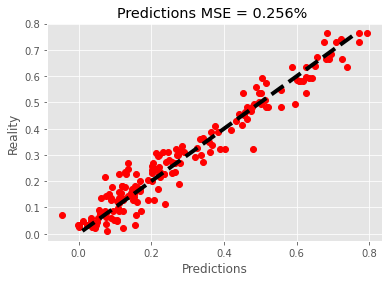

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
fig, ax = plt.subplots()
mse_error  = mean_squared_error(predict_times+y_offset,times)
plt.style.use('ggplot')
plt.plot(predict_times+y_offset, times, 'ro')
plt.xlabel('Predictions', )
plt.ylabel('Reality', )
plt.title('Predictions MSE = {0:.3f}% '.format(mse_error*100))
ax.plot([times.min(), times.max()], [times.min(), times.max()], 'k--', lw=4)
plt.savefig('./')
plt.show()